# ImageNet-1K Data Quality and Model Performance

[ImageNet 1K dataset](https://www.image-net.org/index.php) is an established image classification dataset.
Plenty of the off-shief classification models are trained on it.

In this notebook, we demo how much more we can know from such a public dataset and models.

First, let's load necessary packages and setup DuckDB extensions.

In [1]:
import lance
import duckdb
import torchvision
import torch
import pandas as pd
import pyarrow as pa

In [2]:
%load_ext sql
%sql duckdb:///:memory: --connection_arguments {"preload_extensions":["lance"],"config":{"allow_unsigned_extensions":true}}

{'preload_extensions': ['lance'], 'config': {'allow_unsigned_extensions': True}}


In [10]:
MODE = "demo"

In [11]:
%%time

if MODE == "generate":
    !rm -rf /tmp/imagenet.lance.tar.gz
    !curl https://eto-public.s3.amazonaws.com/datasets/imagenet_1k/imagenet_1k.lance.tar.gz --output /tmp/imagenet.lance.tar.gz

!rm -rf /tmp/imagenet*.lance
!cd /tmp && tar -xvf imagenet.lance.tar.gz

imagenet_1k.lance/
imagenet_1k.lance/_versions/
imagenet_1k.lance/_versions/1.manifest
imagenet_1k.lance/data/
imagenet_1k.lance/data/6ce97b03-67cc-4e72-83ef-9272a4a8a4ed_0.lance
imagenet_1k.lance/_latest.manifest


In [12]:
import json
with open("imagenet_classes.json") as fh:
    json_data = json.load(fh)
imagenet_classes = pd.DataFrame({'label': json_data.keys(), 'name': json_data.values()})
imagenet_classes["label"] = imagenet_classes.label.astype(int)

In [13]:
uri = "/tmp/imagenet_1k.lance"
ds = lance.dataset(uri)

## Basic EDA

Take a look at a few rows

In [14]:
%%sql

SELECT image_id, image_uri, class, split
FROM ds
WHERE class <> ''
USING SAMPLE 10

Took 0.013126373291015625


,image_id,image_uri,class,split
0,n02132136_1064,https://eto-public.s3.amazonaws.com/datasets/i...,"brown bear, bruin, Ursus arctos",train
1,ILSVRC2012_val_00032136,https://eto-public.s3.amazonaws.com/datasets/i...,wall clock,val
2,n02002556_8862,https://eto-public.s3.amazonaws.com/datasets/i...,"white stork, Ciconia ciconia",train
3,n02098413_2308,https://eto-public.s3.amazonaws.com/datasets/i...,"Lhasa, Lhasa apso",train
4,n01985128_3073,https://eto-public.s3.amazonaws.com/datasets/i...,"crayfish, crawfish, crawdad, crawdaddy",train
5,n04243546_3626,https://eto-public.s3.amazonaws.com/datasets/i...,"slot, one-armed bandit",train
6,n03888605_32124,https://eto-public.s3.amazonaws.com/datasets/i...,"parallel bars, bars",train
7,n01608432_1559,https://eto-public.s3.amazonaws.com/datasets/i...,kite,train
8,n03461385_7740,https://eto-public.s3.amazonaws.com/datasets/i...,"grocery store, grocery, food market, market",train
9,n03220513_1105,https://eto-public.s3.amazonaws.com/datasets/i...,dome,train


### Simple summary statistics

You can load Lance datasets into pandas

In [15]:
(ds.scanner(columns=["split"])
 .to_table().to_pandas()
 .split.value_counts())

train    47041
test      8638
val       4001
Name: split, dtype: int64

### Check label distribution

Note the you can also work with Lance datasets using SQL

In [16]:
%%sql label_counts <<

SELECT class, count(class) as count
FROM ds
WHERE split <> 'test'
GROUP BY 1
ORDER BY 2 DESC
LIMIT 10

Took 0.01349186897277832


,class,count
0,boxer,116
1,crane,116
2,"seashore, coast, seacoast, sea-coast",114
3,standard poodle,112
4,stove,108
5,Border collie,107
6,"trailer truck, tractor trailer, trucking rig, ...",107
7,"Doberman, Doberman pinscher",104
8,golden retriever,96
9,basenji,95


<AxesSubplot: xlabel='class'>

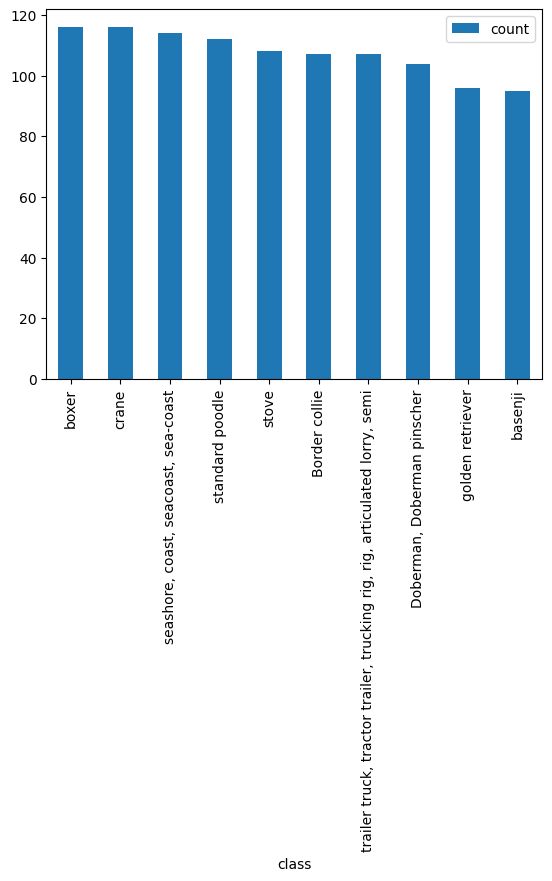

In [17]:
label_counts.set_index('class').plot.bar()

## Model performance

We load two pretrained classic CNN and Transformer models to help us understand the dataset better.

* The ResNet model is based on the [Deep Residual Learning for Image Recognition paper](https://arxiv.org/abs/1512.03385)
* The VisionTransformer model is based on the [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale paper](https://arxiv.org/abs/2010.11929).

Models are moved to the accelerators if available. 
Not only we support CUDA as backend, we support [MPS backend on macOS](https://pytorch.org/docs/stable/notes/mps.html) as well.

In [18]:
from torchvision.models import resnet50, vit_b_16
import torch

# Support CUDA (Linux) or MPS (Mac) backends.
device = torch.device(
    "cuda" if torch.cuda.is_available() else (
        "mps" if torch.backends.mps.is_available() else "cpu")
)

resnet = resnet50(weights="DEFAULT").to(device)
vit = vit_b_16(weights="DEFAULT").to(device)

Lance provides native [PyTorch Dataset](https://eto-ai.github.io/lance/api/python/lance.pytorch.html#lance.pytorch.data.Dataset),
which works with PyTorch DataLoader.

We can write a plain PyTorch evaluation loop and persist the predictions back to the dataset for future analysis.



In [19]:
from lance.pytorch import Dataset

def run_inference(uri: str, model, transform, col_name: str) -> pa.Table:
    dataset = Dataset(
        uri, 
        columns=["image_id", "image"],
        mode="batch",
        batch_size=128
    )
    results = []
    with torch.no_grad():
        model.eval()
        for batch in dataset:
            imgs = [transform(img).to(device) for img in batch[1]]
            prediction = resnet(torch.stack(imgs)).squeeze(0).softmax(0)
            topk = torch.topk(prediction, 2)
            for pk, scores, indices in zip(
                batch[0], topk.values.tolist(), topk.indices.tolist()
            ):
                results.append({
                    "image_id": pk.item(),
                    col_name: {
                        "label": indices[0], 
                        "score": scores[0], 
                        "second_label": indices[1],  # Secondary guess
                        "second_score": scores[1],  # Confidence of the secondary guess.
                    }
                })
    df = pd.DataFrame(data=results)
    return pa.Table.from_pandas(df)

In [20]:
if MODE == 'generate':
    resnet_table = run_inference(
        uri, resnet, torchvision.models.ResNet50_Weights.DEFAULT.transforms(), "resnet"
    )
    vit_table = run_inference(
        uri, vit, torchvision.models.ViT_L_16_Weights.DEFAULT.transforms(), "vit"
    )
    !rm -rf /tmp/resnet_table.lance
    !rm -rf /tmp/vit_table.lance
    lance.write_dataset(resnet_table, "/tmp/resnet_table.lance")
    lance.write_dataset(vit_table, "/tmp/vit_table.lance")
else:
    resnet_table = lance.dataset("/tmp/resnet_table.lance").to_table()
    vit_table = lance.dataset("/tmp/vit_table.lance").to_table()

### Add inference results to dataset without copying

Because Lance supports [Schema Evolution](https://en.wikipedia.org/wiki/Schema_evolution), 
it is quite easy to add new columns from the model inference back to the dataset.

In [ ]:
ds = ds.merge(resnet_table, left_on="image_id", right_on="image_id")
ds = ds.merge(vit_table, left_on="image_id", right_on="image_id")

In [26]:
ds.versions()

[{'version': 1,
  'timestamp': datetime.datetime(2022, 12, 21, 3, 5, 12, tzinfo=datetime.timezone.utc),
  'metadata': {}},
 {'version': 2,
  'timestamp': datetime.datetime(2022, 12, 21, 6, 33, 59, tzinfo=datetime.timezone.utc),
  'metadata': {}},
 {'version': 3,
  'timestamp': datetime.datetime(2022, 12, 21, 6, 33, 59, tzinfo=datetime.timezone.utc),
  'metadata': {}}]

In [27]:
diff = lance.diff(ds, 1, 3).columns_added()

In [28]:
diff.schema

resnet.label: int64
resnet.score: double
resnet.second_label: int64
resnet.second_score: double
vit.label: int64
vit.score: double
vit.second_label: int64
vit.second_score: double

In [30]:
diff.head().to_pandas()

,resnet,vit
0,"{'label': 146, 'score': 0.8724865913391113, 's...","{'label': 146, 'score': 0.8464243412017822, 's..."
1,"{'label': 455, 'score': 0.7859004139900208, 's...","{'label': 455, 'score': 0.7768409252166748, 's..."
2,"{'label': 595, 'score': 0.9477646350860596, 's...","{'label': 595, 'score': 0.9524257779121399, 's..."
3,"{'label': 4, 'score': 0.7104611396789551, 'sec...","{'label': 4, 'score': 0.6638668775558472, 'sec..."
4,"{'label': 14, 'score': 0.8601386547088623, 'se...","{'label': 14, 'score': 0.8557813167572021, 'se..."
5,"{'label': 745, 'score': 0.909288763999939, 'se...","{'label': 745, 'score': 0.9030531644821167, 's..."
6,"{'label': 796, 'score': 0.5023359060287476, 's...","{'label': 796, 'score': 0.34024304151535034, '..."
7,"{'label': 946, 'score': 0.5717235207557678, 's...","{'label': 946, 'score': 0.517687201499939, 'se..."
8,"{'label': 367, 'score': 0.7258750796318054, 's...","{'label': 367, 'score': 0.7997267246246338, 's..."
9,"{'label': 139, 'score': 0.6930319666862488, 's...","{'label': 139, 'score': 0.7330754399299622, 's..."


This versioning happens without manually work or redundant copying

## Model Performance

Using lance and SQL, computing basic ML metrics such as ***precision*** is straightfoward and fast.
SQL support means it's easy to integrate with BI tooling for visualizations

### Model precision

In [31]:
%%sql precision <<

SELECT 
  SUM(CAST(resnet.label = ic.label AS FLOAT)) / COUNT(ic.label) as resnet,
  SUM(CAST(vit.label = ic.label AS FLOAT)) / COUNT(ic.label) as vit
FROM ds inner join imagenet_classes as ic on ds.class = ic.name
WHERE split = 'val'

Took 0.02257061004638672


,resnet,vit
0,0.543142,0.535411


<AxesSubplot: >

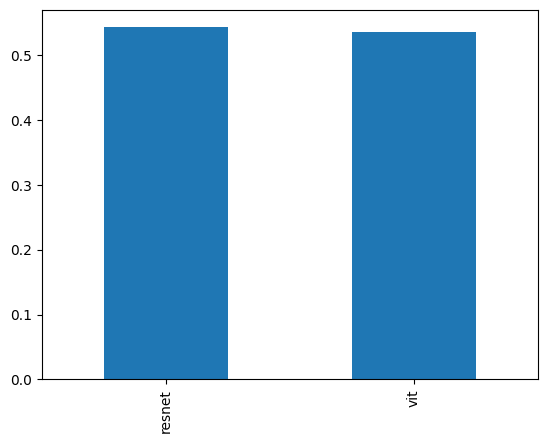

In [32]:
precision.T.rename(columns={0: 'precision'}).squeeze().plot.bar()

### Metrics across arbitrary dimensions

With Lance, it is trivial to slice into each label class to detailed model performance in each class.

In [33]:
%%sql precision_by_class <<

SELECT
  DISTINCT(ds.class) as class,
  SUM(CAST(resnet.label = ic.label AS FLOAT)) / COUNT(ds.class) as resnet,
  SUM(CAST(vit.label = ic.label AS FLOAT)) / COUNT(ds.class) as vit
FROM ds inner join imagenet_classes as ic on ds.class = ic.name
WHERE split = 'val'
GROUP BY 1
ORDER BY resnet ASC

Took 0.024695396423339844


,class,resnet,vit
0,tiger cat,0.0,0.00
1,ox,0.0,0.00
2,"ram, tup",0.0,0.00
3,"polecat, fitch, foulmart, foumart, Mustela put...",0.0,0.00
4,"squirrel monkey, Saimiri sciureus",0.0,0.25
...,...,...,...
994,"handkerchief, hankie, hanky, hankey",1.0,1.00
995,volcano,1.0,1.00
996,tiger beetle,1.0,1.00
997,space shuttle,1.0,1.00


<AxesSubplot: xlabel='class'>

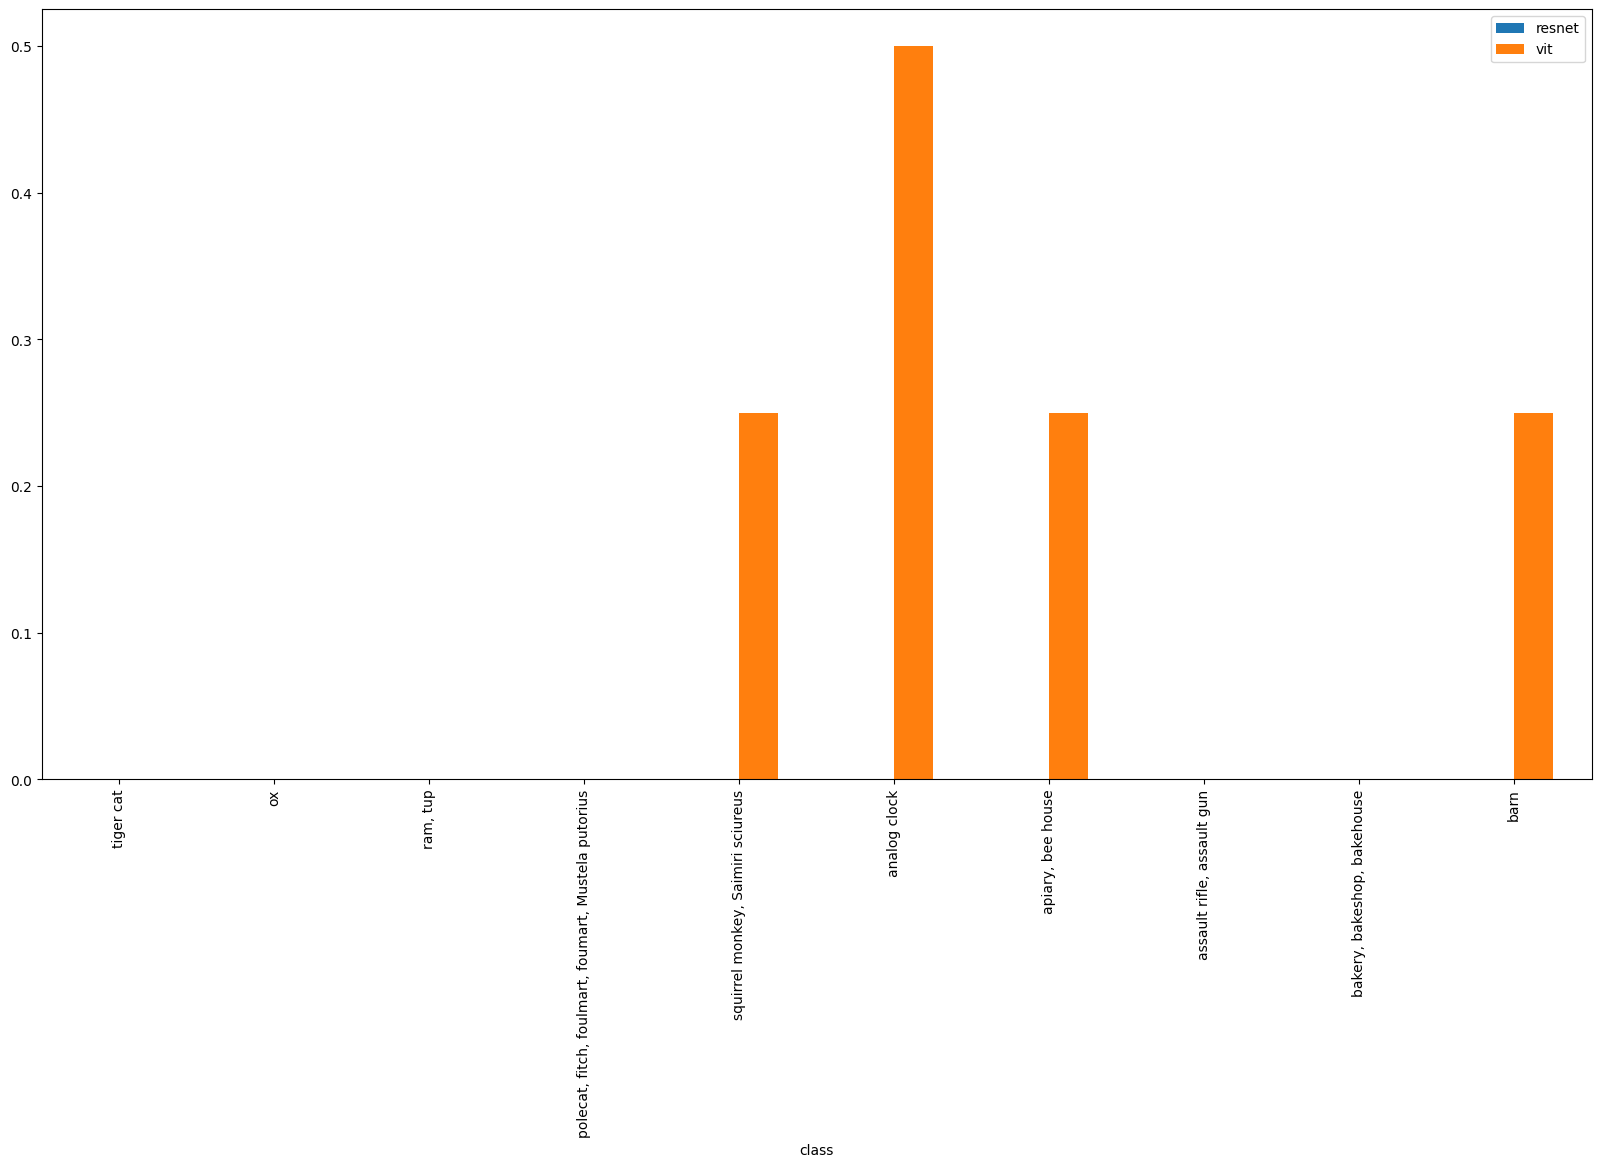

In [34]:
precision_by_class.head(10).set_index('class').plot.bar(figsize=(20,10))

### Confusion matrix

In [35]:
%%sql confusion <<

WITH label_names AS (SELECT DISTINCT label, name FROM imagenet_classes)

SELECT ds.class as gt, label_names.name as resnet
FROM ds, label_names
WHERE ds.resnet.label=label_names.label

Took 0.16859889030456543


,gt,resnet
0,"coho, cohoe, coho salmon, blue jack, silver sa...","tench, Tinca tinca"
1,"goldfish, Carassius auratus","goldfish, Carassius auratus"
2,"hammerhead, hammerhead shark","great white shark, white shark, man-eater, man..."
3,"great white shark, white shark, man-eater, man...","tiger shark, Galeocerdo cuvieri"
4,"hammerhead, hammerhead shark","hammerhead, hammerhead shark"
...,...,...
59675,hornbill,sliding door
59676,"home theater, home theatre",sliding door
59677,"hippopotamus, hippo, river horse, Hippopotamus...",sliding door
59678,hen,sliding door


In [36]:
rs = confusion.reset_index().groupby(['gt', 'resnet']).count().reset_index().rename(columns={'index': 'count'})

In [37]:
rs["pct"] = rs.groupby("gt", group_keys=False)["count"].apply(lambda grp: grp / grp.sum())

<AxesSubplot: xlabel='gt', ylabel='resnet'>

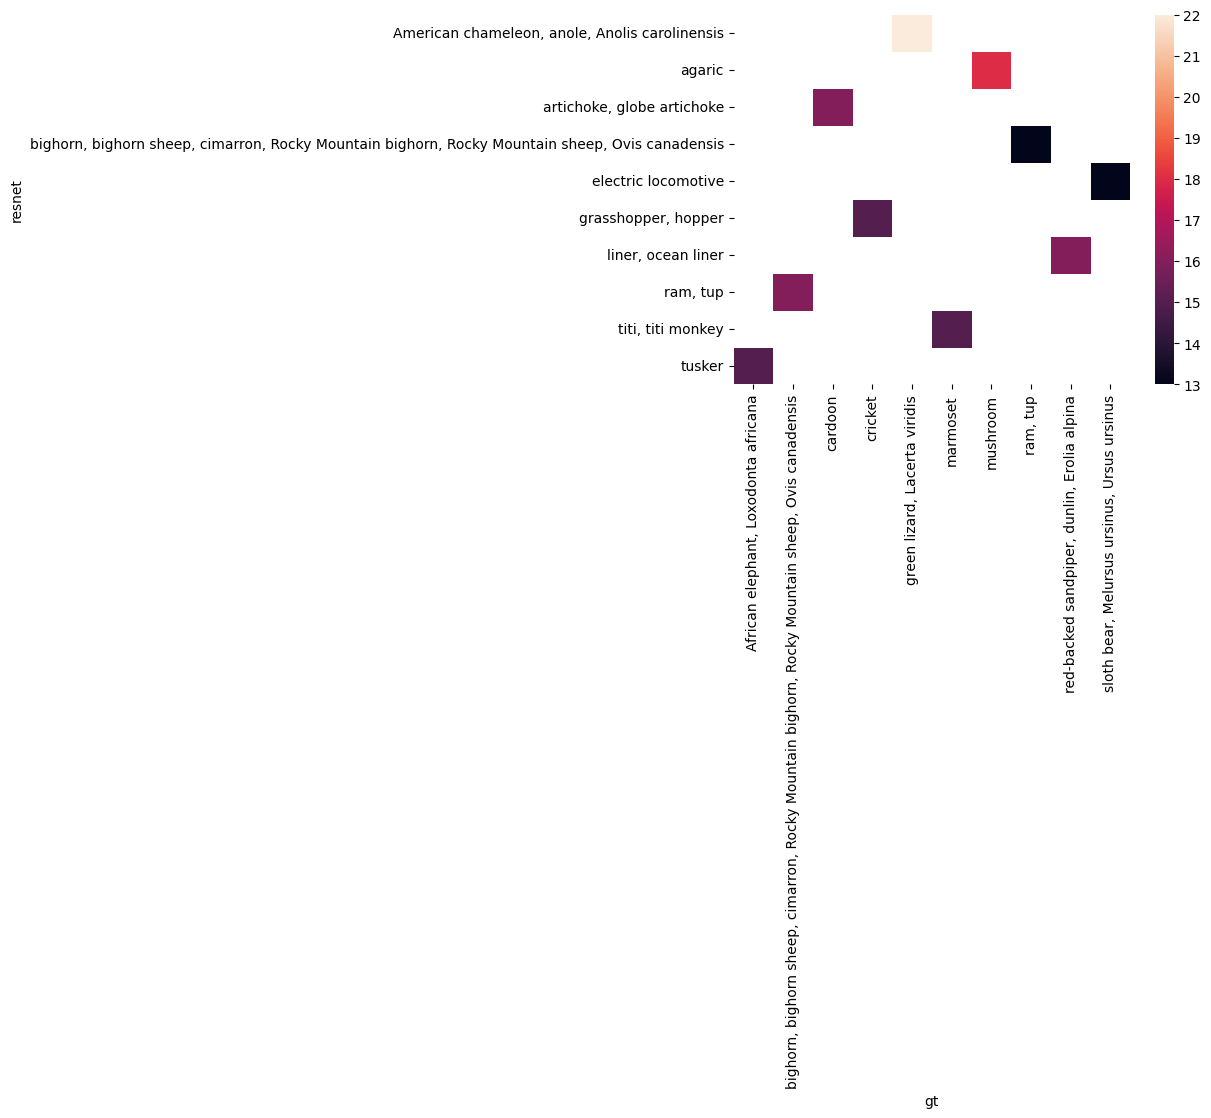

In [38]:
import seaborn as sns

sns.heatmap((rs[rs["gt"] != rs["resnet"]]
             .sort_values("pct", ascending=False).head(10)
             .set_index(["gt", "resnet"])["count"].unstack("gt")))

<div class="alert alert-block alert-info"> 
    💡 INSIGHT: top confused classes are very similar, e.g., "maillot" vs "maillot, tank suit", "laptop" vs "notebook", "missile" vs "projectile, missile"       
</div>

## Automatically Detecting Mislabels

To find potential mislables, we first need to automately establish a baseline of what consider as correct labels.
We establish the baseline via the agreements of the two pre-trained models inference results. That is,
if the two models strongly agree with each other (i.e., same label and confience score is high), but the predict label is not what ground truth describes.

Such logic can be easily expressed via SQL:

In [ ]:
%%sql --lance

WITH label_names AS (SELECT DISTINCT label, name FROM imagenet_classes)

SELECT ds.image_id,
       ds.image_uri,
       ds.class AS ground_truth,
       n2.name as predict,
       resnet.score as score
FROM ds, label_names as n1, label_names as n2
WHERE
  split != 'test'
  AND n1.label !=  resnet.label 
  AND resnet.label = vit.label
  AND ds.class = n1.name
  AND resnet.label = n2.label
ORDER BY resnet.score DESC
LIMIT 20

While `zucchini` can look similar to `cucumber`, it defintely worths to investigate why the models think `cowboy hat` as `cowboy boot`, and `beaker` as `ping-pong ball`.

# We can review the mislabels and send them to labelstudio

In [ ]:
from labelstudio import LanceLabelStudioClient as Client

ls = Client.create()
p = ls.get_project("imagenet")

p.add_tasks(sql_result_set.df.head(5), image_col="image_uri", pk_col="image_id")

## Once they're labeled we can merge it back into the dataset

In [ ]:
import pyarrow as pa
label_df = p.get_annotations("label_studio_labels")

schema = pa.schema([pa.field('id', pa.string()),
                    pa.field('label_studio_labels', pa.string())])
tbl = pa.Table.from_pandas(label_df, schema)

ds.merge(tbl, left_on='image_id', right_on='id')

BTW, Lance automatically versions the changes so it's easy to diff and rollback

In [ ]:
diff = lance.diff(ds, 3, 4).columns_added()
diff.schema

In [ ]:
df = diff.head(n=ds.count_rows()).to_pandas()
df[df.label_studio_labels != ""]

### Use Lance's native streaming pytorch integration to retrain without conversion / copying

In [ ]:
import pyarrow.compute as pc

dataset = Dataset(
    uri,
    filter=pc.field("split") == "train",
    columns=["image_id", "class", "image"],  # only read certain columns
    batch_size=1
)

for batch in dataset:
    print(batch)
    break

## Active Learning in Lance

With Lance and DuckDB, it is easy to build active learning loop as well.

One typical approach of Active Learning is finding `Lowest Margin of Confidence`. 

This query finds the examples where a model (*ResNet* in this case) is less confident between the top two candidates.

In [41]:
%%sql least_margin <<

WITH label_names AS (SELECT DISTINCT label, name FROM imagenet_classes)

SELECT    
    ds.image_id,
    ds.image_uri,
    n1.name as best_guess,
    n2.name as second_guess,
    resnet.score - resnet.second_score AS margin_of_confidence
FROM ds, label_names as n1, label_names as n2
WHERE 
    split != 'test'
    AND n1.label = resnet.label
    AND n2.label = resnet.second_label
ORDER BY margin_of_confidence
LIMIT 20

Took 0.05393862724304199


,image_id,image_uri,best_guess,second_guess,margin_of_confidence
0,n02120079_488,https://eto-public.s3.amazonaws.com/datasets/i...,"Arctic fox, white fox, Alopex lagopus","white wolf, Arctic wolf, Canis lupus tundrarum",3.166497e-07
1,n01986214_13172,https://eto-public.s3.amazonaws.com/datasets/i...,"chambered nautilus, pearly nautilus, nautilus",hermit crab,6.230548e-07
2,n07718472_1125,https://eto-public.s3.amazonaws.com/datasets/i...,"squirrel monkey, Saimiri sciureus",vending machine,1.080334e-06
3,n02117135_1302,https://eto-public.s3.amazonaws.com/datasets/i...,Sussex spaniel,black-and-tan coonhound,1.128763e-06
4,n02363005_555,https://eto-public.s3.amazonaws.com/datasets/i...,Sussex spaniel,beaver,1.627952e-06
5,n01824575_3771,https://eto-public.s3.amazonaws.com/datasets/i...,dung beetle,coucal,1.665205e-06
6,n04399382_13306,https://eto-public.s3.amazonaws.com/datasets/i...,"limousine, limo","teddy, teddy bear",2.125278e-06
7,n04204238_3491,https://eto-public.s3.amazonaws.com/datasets/i...,"mailbag, postbag",tripod,2.488494e-06
8,n02860847_26913,https://eto-public.s3.amazonaws.com/datasets/i...,"jean, blue jean, denim","shoe shop, shoe-shop, shoe store",2.728775e-06
9,n01601694_10503,https://eto-public.s3.amazonaws.com/datasets/i...,"water ouzel, dipper","junco, snowbird",3.104098e-06


### Now let's find similar examples in out-of-distribution data

In [42]:
if MODE == "generate":
    !curl https://eto-public.s3.amazonaws.com/datasets/imagenet_1k/imagenet1k_20k.lance.tar.gz --output /tmp/out_of_sample.lance.tar.gz
!cd /tmp && tar -xvf out_of_sample.lance.tar.gz

imagenet1k_20k.lance/
imagenet1k_20k.lance/_versions/
imagenet1k_20k.lance/_versions/1.manifest
imagenet1k_20k.lance/data/
imagenet1k_20k.lance/data/d57ca64d-2500-4a6e-ac96-9d6f8f0529da_0.lance
imagenet1k_20k.lance/_latest.manifest


In [43]:
import pyarrow as pa

In [44]:
from torchvision.models.feature_extraction import create_feature_extractor

resnet = resnet50(weights="DEFAULT")
resnet_extractor = create_feature_extractor(resnet, {"avgpool": "features"}).to("cuda")
resnet_extractor.eval()

resnet_transforms = torchvision.models.ResNet50_Weights.DEFAULT.transforms()


def compute_resnet_embeddings(uri):
    image_ids = []
    embeddings = []
    with torch.no_grad():
        for batch in Dataset(uri,
                             columns=["image_id", "image"],
                             mode="batch", batch_size=128):
            imgs = torch.stack([resnet_transforms(img) for img in batch[1]]).to("cuda")
            resnet_out = resnet_extractor(imgs)["features"].squeeze()
            features = torch.softmax(resnet_out, dim=1).cpu()
            embeddings.extend(features.tolist())
            image_ids.extend(batch[0])
            
    emb_type = pa.list_(pa.float32(), list_size=2048)
    arrays = [pa.array(image_ids), pa.array(embeddings, type=emb_type)]
    schema=pa.schema([pa.field("image_id", pa.string()), 
                      pa.field("embedding", emb_type)])

    tbl = pa.Table.from_arrays(arrays, schema=schema)
    return tbl

Compute embeddings for out-of-distribution data

In [49]:
uri = "/tmp/imagenet1k_20k.lance"
if MODE == "generate":
    embeddings = compute_resnet_embeddings(uri)
    !rm -rf /tmp/embeddings.lance
    lance.write_dataset(embeddings, '/tmp/embeddings.lance')
else:
    embeddings = lance.dataset("/tmp/embeddings.lance").to_table()

In [50]:
out_of_sample = lance.dataset(uri)
out_of_sample.merge(embeddings, left_on="image_id", right_on="image_id")
out_of_sample = lance.dataset(uri)

Compute embeddings for training set using same model

In [53]:
uri = "/tmp/imagenet_1k.lance"
if MODE == "generate":
    embeddings = compute_resnet_embeddings(uri)
    !rm -rf /tmp/embeddings_train.lance
    lance.write_dataset(embeddings, '/tmp/embeddings_train.lance')
else:
    embeddings = lance.dataset("/tmp/embeddings_train.lance").to_table()

In [54]:
training_set = lance.dataset(uri)
training_set.merge(embeddings, left_on="image_id", right_on="image_id")
training_set = lance.dataset(uri)

### Lance has ML functions for duckdb to compute similarity

In [55]:
least_margin.iloc[0]

image_id                                                    n02120079_488
image_uri               https://eto-public.s3.amazonaws.com/datasets/i...
best_guess                          Arctic fox, white fox, Alopex lagopus
second_guess               white wolf, Arctic wolf, Canis lupus tundrarum
margin_of_confidence                                                  0.0
Name: 0, dtype: object

In [56]:
%%sql --lance

with ref as (select embedding from training_set where image_id='n02120079_488')

SELECT image_id, image_uri, l2_distance(oos.embedding, ref.embedding) as similarity
FROM out_of_sample oos cross join ref
ORDER BY 3
LIMIT 10

Took 1.912867784500122


### Label then re-train

Just like we did before, using LabelStudio integration and pytorch integration, it's easy to add these new data points to your dataset and improve your model

## Lance makes it super-simple to create a Data-Driven ML development loop

- Get insights in under 100ms via duckdb or pandas

- Save labeling cost by only sending samples that need to be labeled to Scale/LabelBox. Or totally free using LabelStudio.

- Lance dashboards and insights are customizable so you can tailor it to your use case exactly